In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
%matplotlib inline

## A/B Testing

In [2]:
baby = Table.read_table('http://inferentialthinking.com/notebooks/baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
baby.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


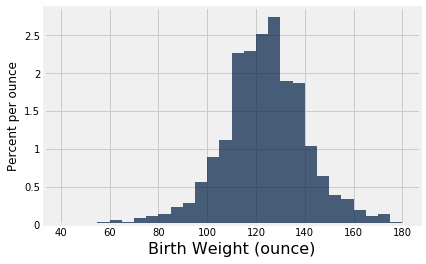

In [4]:
weight_bins = np.arange(40, 181, 5)
baby.where('Maternal Smoker', False).hist('Birth Weight', bins=weight_bins, unit='ounce')

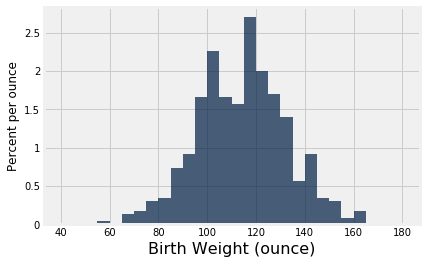

In [5]:
baby.where('Maternal Smoker', True).hist('Birth Weight', bins=weight_bins, unit='ounce')

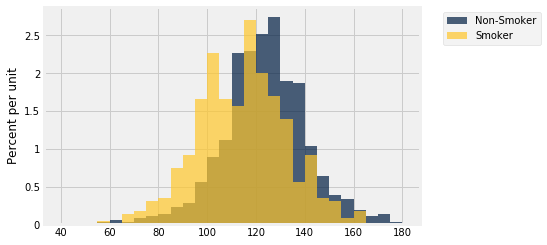

In [6]:
baby.where('Maternal Smoker', False).bin('Birth Weight', bins=weight_bins).join(
    'bin', baby.where('Maternal Smoker', True).bin('Birth Weight', bins=weight_bins)
).relabeled(1, 'Non-Smoker').relabeled(2, 'Smoker').hist(bin_column='bin')

In [7]:
smoke_weight = baby.select('Maternal Smoker', 'Birth Weight')
means = smoke_weight.group('Maternal Smoker', np.mean)
means

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [8]:
def abs_difference_in_means(t):
    means = t.group(0, np.mean)
    return abs(means.column(1).item(0) - means.column(1).item(1))

abs_difference_in_means(smoke_weight)

9.266142572024918

Observed statistic: 9.266142572024918
P-value: 0.0


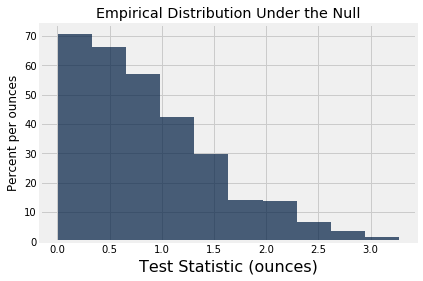

In [9]:
t = baby.select('Maternal Smoker', 'Birth Weight')
observed = abs_difference_in_means(t)
repetitions = 1000
    
# Assuming the null is true, randomly permute the variable 
# and collect all the generated test statistics
stats = make_array()
for i in np.arange(repetitions):
    simulated_wts = t.select('Birth Weight').sample()
    simulated_moms = t.select('Maternal Smoker').sample()
    simulated_outcomes = Table().with_column(
        'Maternal Smoker', simulated_moms.column(0),
        'Birth Weight', simulated_wts.column(0))
    simulated_stat = abs_difference_in_means(simulated_outcomes)
    stats = np.append(stats, simulated_stat)
    
# Find the empirical P-value:
p = np.count_nonzero(stats >= observed) / repetitions

# Draw the empirical histogram of the test statistic
# generated based on the null hypothesis,
# and compare with the value observed in the original sample
Table().with_column('Test Statistic', stats).hist(unit='ounces')
plots.title('Empirical Distribution Under the Null')
print('Observed statistic:', observed)
print('P-value:', p)

## Causality and Randomized Controlled Trials

In [10]:
bta = Table.read_table('http://inferentialthinking.com/notebooks/bta.csv')
bta

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [11]:
bta.group('Group', np.mean)

Group,Result mean
Control,0.125
Treatment,0.6


In [12]:
abs_difference_in_means(bta)

0.475

Observed statistic: 0.475
P-value: 0.008


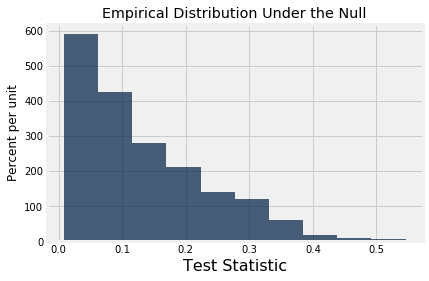

In [13]:
t = bta.select('Group', 'Result')
observed = abs_difference_in_means(t)
repetitions = 1000
    
# Assuming the null is true, randomly permute the variable 
# and collect all the generated test statistics
stats = make_array()
for i in np.arange(repetitions):
    simulated_results = t.select('Result').sample()
    simulated_groups = t.select('Group').sample(with_replacement=False)
    simulated_outcomes = Table().with_column(
        'Group', simulated_groups.column(0),
        'Result', simulated_results.column(0))
    simulated_stat = abs_difference_in_means(simulated_outcomes)
    stats = np.append(stats, simulated_stat)
    
# Find the empirical P-value:
p = np.count_nonzero(stats >= observed) / repetitions

# Draw the empirical histogram of the test statistic
# generated based on the null hypothesis,
# and compare with the value observed in the original sample
Table().with_column('Test Statistic', stats).hist()
plots.title('Empirical Distribution Under the Null')
print('Observed statistic:', observed)
print('P-value:', p)

## Alternative Test: Permutation Tests

In [14]:
def difference_in_means(t):
    means = t.group(0, np.mean)
    return means.column(1).item(0) - means.column(1).item(1)

difference_in_means(smoke_weight)

9.266142572024918

In [ ]:
def permutation_test_means(table, variable, classes, repetitions, unit=None):
    """Test whether two numerical samples 
    come from the same underlying distribution, 
    using the absolute difference between the means.
    table: name of table containing the sample
    variable: label of column containing the numerical variable 
    classes: label of column containing names of the two samples
    repetitions: number of random permutations
    
    variable -- Label for a numerical variable in table
    classes -- Label for a two-category (A & B) variable in table
    """
    
    t = table.select(classes, variable)
    observed = abs(difference_in_means(t))
    
    # Assuming the null is true, randomly permute the variable 
    # and collect all the generated test statistics
    stats = make_array()
    for i in np.arange(repetitions):
        shuffled_var = t.select(variable).sample(with_replacement=False).column(0)
        shuffled = t.select(classes).with_column('Shuffled Variable', shuffled_var)
        new_stat = abs(difference_in_means(shuffled))
        stats = np.append(stats, new_stat)
    
    # Find the empirical P-value:
    p = np.count_nonzero(stats >= observed) / repetitions

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    Table().with_column('Test Statistic', stats).hist(unit=unit)
    plots.title('Empirical Distribution Under the Null')
    print('Observed statistic:', observed)
    print('Empirical P-value:', p)

In [ ]:
permutation_test_means(baby, 'Birth Weight', 'Maternal Smoker', 1000, 'ounce')

In [ ]:
permutation_test_means(bta, 'Result', 'Group', 1000)